1. Генерація послідовностей 
Вирішіть завдання генерації послідовностей  (архітектура за вашим вибором:  seq2seq  на 
основі RNN, або RNN+TeacherForcing, абоTransformer) 
Для навчання можно сгенерувати синтетічні дані (часові ряди), або (що краще)  взяти 
датасети для машинного перекладу

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import numpy as np
import random

In [28]:
n_timesteps_in = 50 # length of input sequence
n_timesteps_out = 40 # length of output sequence

n_features_in = 1
n_features_out = 1

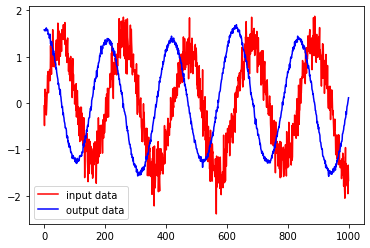

In [29]:
#generate dataset
time_series_length = 1000
t = np.linspace(0, 10, time_series_length)
ts_input = np.sin(t) / 5 + 1.5 * np.sin(t*3) + 0.3 * np.random.standard_normal(size=time_series_length)
ts_output = np.cos(t) / 2 + 4 * np.cos(t*3) + 0.1 * np.random.standard_normal(size=time_series_length)
# normalize the data
ts_norm_input = (ts_input - np.mean(ts_input)) / np.std(ts_input)
ts_norm_output = (ts_output - np.mean(ts_output)) / np.std(ts_output)
plt.plot(ts_norm_input, 'r', label = 'input data')
plt.plot(ts_norm_output,'b', label = 'output data')

plt.legend()

In [30]:
train_size = int(len(ts_input) * 0.8)
test_size = len(ts_input) - train_size

train_input, test_input = ts_norm_input[0:train_size], ts_norm_input[train_size:len(ts_input)]
train_output, test_output = ts_norm_output[0:train_size], ts_norm_output[train_size:len(ts_input)]

In [31]:
seq_len = max(n_timesteps_in, n_timesteps_out)
def create_dataset():
    # train data
    train_input_data, train_output_data = [], []
    for i in range(500):
        rand_ind_train = random.randint(0, len(train_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_train:rand_ind_train+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_train:rand_ind_train+n_timesteps_out]
        train_input_data.append(input_seq)
        train_output_data.append(output_seq)
    # test data
    test_input_data, test_output_data = [], []   
    for i in range(5):
        rand_ind_test = random.randint(0, len(test_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_test:rand_ind_test+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_test:rand_ind_test+n_timesteps_out]
        test_input_data.append(input_seq)
        test_output_data.append(output_seq)
    return np.array(train_input_data), np.array(train_output_data), np.array(test_input_data), np.array(test_output_data)

In [32]:
train_input_data, train_output_data, test_input_data, test_output_data = create_dataset()

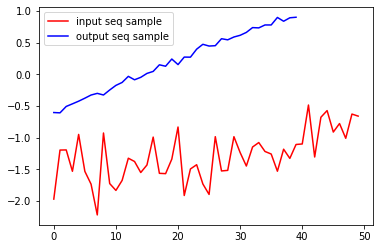

In [33]:
plt.plot(train_input_data[0], 'r', label = 'input seq sample')
plt.plot(train_output_data[0], 'b', label = 'output seq sample')
plt.legend()

In [34]:
# reshape input to be [n_samples, n_time_steps, n_features]
train_input_data = np.reshape(train_input_data, (train_input_data.shape[0], n_timesteps_in, n_features_in))
train_output_data = np.reshape(train_output_data, (train_input_data.shape[0], n_timesteps_out, n_features_out))

test_input_data = np.reshape(test_input_data, (test_input_data.shape[0], n_timesteps_in, n_features_in))
test_output_data = np.reshape(test_output_data, (test_input_data.shape[0], n_timesteps_out, n_features_out))

In [35]:
n_units = 128

encoder_inputs = keras.Input(shape=(n_timesteps_in, n_features_in))
encoder = keras.layers.LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

# Set up the decoder, using 'encoder_states' as initial state.
decoder_inputs = keras.Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  keras.layers.LSTM(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [36]:
print(model.summary())
model.compile(optimizer='adam', loss='mse')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50, 1)]      0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 40, 1)]      0           []                               
                                                                                                  
 lstm_4 (LSTM)                  [(None, 128),        66560       ['input_5[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

In [37]:
decoder_inputs = np.zeros(train_output_data.shape)

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

model.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=100, batch_size=64, validation_split=0.2, callbacks = my_callbacks, verbose=2)

Epoch 1/100
7/7 - 5s - loss: 0.9021 - val_loss: 0.7758 - 5s/epoch - 671ms/step
Epoch 2/100
7/7 - 1s - loss: 0.6717 - val_loss: 0.5618 - 516ms/epoch - 74ms/step
Epoch 3/100
7/7 - 0s - loss: 0.4997 - val_loss: 0.3982 - 488ms/epoch - 70ms/step
Epoch 4/100
7/7 - 0s - loss: 0.3137 - val_loss: 0.1537 - 496ms/epoch - 71ms/step
Epoch 5/100
7/7 - 0s - loss: 0.1334 - val_loss: 0.1080 - 490ms/epoch - 70ms/step
Epoch 6/100
7/7 - 0s - loss: 0.0928 - val_loss: 0.0673 - 484ms/epoch - 69ms/step
Epoch 7/100
7/7 - 0s - loss: 0.0672 - val_loss: 0.0520 - 489ms/epoch - 70ms/step
Epoch 8/100
7/7 - 0s - loss: 0.0685 - val_loss: 0.0449 - 485ms/epoch - 69ms/step
Epoch 9/100
7/7 - 1s - loss: 0.0522 - val_loss: 0.0399 - 639ms/epoch - 91ms/step
Epoch 10/100
7/7 - 1s - loss: 0.0379 - val_loss: 0.0414 - 551ms/epoch - 79ms/step
Epoch 11/100
7/7 - 1s - loss: 0.0350 - val_loss: 0.0280 - 604ms/epoch - 86ms/step
Epoch 12/100
7/7 - 0s - loss: 0.0310 - val_loss: 0.0247 - 494ms/epoch - 71ms/step
Epoch 13/100
7/7 - 0s - los

In [38]:
decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model.predict([test_input_data, decoder_inputs])

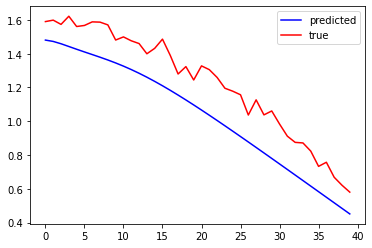

In [39]:
plt.plot(y_pred[0], 'b', label = 'predicted')
plt.plot(test_output_data[0], 'r', label = 'true')

plt.legend()

2. Генерація зображень  
Вирішіть  завдання  генерації  зображень  (архітектура  за  вашим  вибором: 
GAN/DCGAN/VAE/CVAE), якщо в обраному датасеті багато класів, залиште декілька

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import initializers

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1000)

import pandas as pd

In [53]:
data_train = pd.read_csv('fashion-mnist_train.csv')
data_train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
x_train = data_train.drop('label',axis=1)
x_train

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,0,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
y_train = data_train['label'];
y_train

0        2
1        9
2        6
3        0
4        3
        ..
59995    9
59996    1
59997    8
59998    8
59999    7
Name: label, Length: 60000, dtype: int64

In [56]:
data_test = pd.read_csv('fashion-mnist_test.csv')
data_test

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [57]:
x_test = data_test.drop('label',axis=1)
x_test

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,9,8,0,...,103,87,56,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,0,63,53,31,0,0,0
3,0,0,0,0,0,0,0,0,0,161,...,137,126,140,0,133,224,222,56,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,37,...,32,23,14,20,0,0,1,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,0,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [59]:
y_test = data_test['label'];
y_test

0       0
1       1
2       2
3       2
4       3
       ..
9995    0
9996    6
9997    8
9998    8
9999    1
Name: label, Length: 10000, dtype: int64

In [68]:
print(x_train.shape[0], 'train samples')

60000 train samples


In [74]:
input_dim = 784
x_train = x_train.values.reshape(60000, input_dim)
print('input shape: ', x_train.shape[1])
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normilization [-1, 1]
x_train

input shape:  784


array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

In [75]:
optim = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [76]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(1024, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [77]:
latent_dim = 100

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model  

In [78]:
discriminator = build_discriminator()
generator = build_generator()

# Combined network
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim)

In [79]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap = 'gray')
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [80]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            
             # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 20 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)

epoch:  0


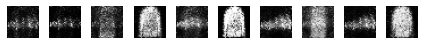

epoch:  20


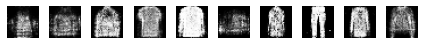

epoch:  40


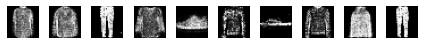

epoch:  60


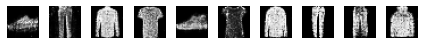

epoch:  80


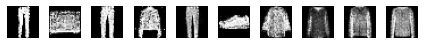

epoch:  100


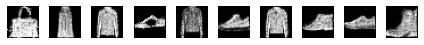

In [81]:
epochs = 100
batch_size = 128
train_model(epochs, batch_size)

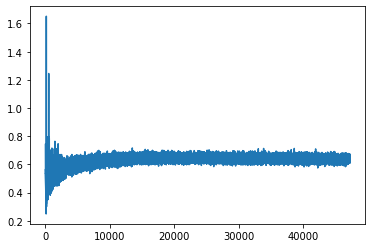

In [82]:
plt.plot(discrim_losses)